In [1]:
import keras
import scipy
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import layers

import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

plt.rc('font', size=12)          # controls default text sizes
plt.rc('axes', titlesize=12)     # fontsize of the axes title
plt.rc('axes', labelsize=15)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
plt.rc('legend', fontsize=15)    # legend fontsize

In [2]:
def Race(v, b, ndt=0, dt=0.001):
    x = np.array([0.0, 0.0])
    rt = 0
    ch = -1
    stop = False
    while not stop:
        x[0] += v[0]*dt + np.random.normal(0, 1)*np.sqrt(dt)
        x[1] += v[1]*dt + np.random.normal(0, 1)*np.sqrt(dt)
        rt += dt
        if x[0]>= b and x[1]<b:
            ch = 0.0
            stop = True
        elif x[1]>= b and x[0]<b:
            ch = 1.0
            stop = True
        elif x[0]>= b and x[1]>=b:
            rt = 0
            x = np.array([0.0, 0.0])
    return rt+ndt, ch

In [3]:
data_df = pd.read_csv('../../_data/Kr2010.csv', index_col=0)

min_rt = data_df.groupby(by='sbj')['rt'].min()

tr_df, ts_df = data_df.copy(), data_df.copy()

obs_train = np.asarray(data_df[['rt', 'Right']])
X_train = np.asarray(data_df[['item_value_1', 'item_value_2', 'gaze_1', 'gaze_2']])

obs_test = np.asarray(data_df[['rt', 'Right']])
X_test = np.asarray(data_df[['item_value_1', 'item_value_2', 'gaze_1', 'gaze_2']])

print(X_train.shape, X_test.shape)

(3522, 4) (3522, 4)


In [4]:
def fpt(t, b, v):
    return tf.cast(tf.math.greater(t, 0), tf.float32)*(b/(2*np.pi*t**3)**(1/2) * keras.backend.exp(-1/(2*t) * (v*t-b)**2)) + tf.cast(tf.math.less_equal(t, 0), tf.float32)*0.1**10

def phi(x):
    return 0.5*tf.math.erf(x/tf.sqrt(2.0)) + 0.5

def cdf(t, b, v):
    return tf.cast(tf.math.greater(t, 0), tf.float32)*(phi((v*t-b)/tf.sqrt(t)) + tf.exp(2*v*b)*phi((-v*t-b)/tf.sqrt(t))) + (tf.cast(tf.math.less_equal(t, 0), tf.float32)*0)

def G2(data, pred):
    ndt = tf.convert_to_tensor([min_rt[i]*tf.math.sigmoid(model.layers[-1].weights[-1][i-1]) for i in tr_df['sbj']])
    thr = tf.convert_to_tensor([tf.math.log(1 + tf.exp(model.layers[-1].weights[-2][i-1])) for i in tr_df['sbj']])
    scl = tf.convert_to_tensor([tf.math.log(1 + tf.exp(model.layers[-1].weights[-3][i-1])) for i in tr_df['sbj']])
    
    ll1 = (1 - obs_train[:, 1]) * fpt(obs_train[:, 0]-ndt, thr, scl*pred[:, 0]) * (1.0 - cdf(obs_train[:, 0]-ndt, thr, scl*pred[:, 1]))
    ll2 = (obs_train[:, 1]) * fpt(obs_train[:, 0]-ndt, thr, scl*pred[:, 1]) * (1.0 - cdf(obs_train[:, 0]-ndt, thr, scl*pred[:, 0]))
    
    return -2*tf.reduce_sum(tf.math.log(ll1 + ll2), axis=-1)

In [5]:
class Out_layer(keras.layers.Layer):
    def __init__(self, units=2, input_dim=32, n_sbj_prms=10):
        super().__init__()
        self.w = self.add_weight(shape=(input_dim, units), initializer="random_normal", trainable=True)
        self.b = self.add_weight(shape=(units,), initializer="uniform", trainable=True)
        
        self.scaling = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)
        self.threshold = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)
        self.non_decision_time = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)

    def call(self, inputs):
        return tf.math.log(1 + tf.exp(tf.matmul(inputs, self.w) + self.b))
    
def make_model(layers_neuron, input_shape, output_shape, activation, n_sbj_prms):
    keras.backend.clear_session()

    model = keras.Sequential()
    model.add(layers.Input(shape=(input_shape,)))
    
    for l in layers_neuron:
        model.add(layers.Dense(l, activation=activation))
    
    model.add(Out_layer(units=output_shape, input_dim=layers_neuron[-1], n_sbj_prms=n_sbj_prms))

    print(model.summary())
    
    return model

In [6]:
layers_neuron = [10, 10, 8, 5]
input_shape = 4
output_shape = 2
activation = 'tanh'
n_sbj = data_df.sbj.nunique()

model = make_model(layers_neuron, input_shape, output_shape, activation, n_sbj)

model.build()
model.compile(optimizer="RMSprop", loss=G2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                50        
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 8)                 88        
                                                                 
 dense_3 (Dense)             (None, 5)                 45        
                                                                 
 out_layer (Out_layer)       (None, 2)                 129       
                                                                 
Total params: 422 (1.65 KB)
Trainable params: 422 (1.65 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [7]:
history = model.fit(X_train, 
                    obs_train, 
                    shuffle=False, 
                    batch_size=X_train.shape[0], 
                    epochs=4000)

Epoch 1/4000
1/1 [==============================] - 96s 96s/step - loss: 21542.5332
Epoch 2/4000
1/1 [==============================] - 0s 29ms/step - loss: 21446.7227
Epoch 3/4000
1/1 [==============================] - 0s 22ms/step - loss: 21379.5430
Epoch 4/4000
1/1 [==============================] - 0s 23ms/step - loss: 21323.7480
Epoch 5/4000
1/1 [==============================] - 0s 31ms/step - loss: 21274.3398
Epoch 6/4000
1/1 [==============================] - 0s 23ms/step - loss: 21229.0137
Epoch 7/4000
1/1 [==============================] - 0s 23ms/step - loss: 21186.4863
Epoch 8/4000
1/1 [==============================] - 0s 22ms/step - loss: 21145.9531
Epoch 9/4000
1/1 [==============================] - 0s 22ms/step - loss: 21106.9316
Epoch 10/4000
1/1 [==============================] - 0s 21ms/step - loss: 21069.1035
Epoch 11/4000
1/1 [==============================] - 0s 22ms/step - loss: 21032.2676
Epoch 12/4000
1/1 [==============================] - 0s 21ms/step - loss: 

1/1 [==============================] - 0s 32ms/step - loss: 18761.6816
Epoch 98/4000
1/1 [==============================] - 0s 31ms/step - loss: 18742.0918
Epoch 99/4000
1/1 [==============================] - 0s 32ms/step - loss: 18722.6387
Epoch 100/4000
1/1 [==============================] - 0s 31ms/step - loss: 18703.3164
Epoch 101/4000
1/1 [==============================] - 0s 33ms/step - loss: 18684.1211
Epoch 102/4000
1/1 [==============================] - 0s 32ms/step - loss: 18665.0586
Epoch 103/4000
1/1 [==============================] - 0s 32ms/step - loss: 18646.1191
Epoch 104/4000
1/1 [==============================] - 0s 33ms/step - loss: 18627.3066
Epoch 105/4000
1/1 [==============================] - 0s 32ms/step - loss: 18608.6172
Epoch 106/4000
1/1 [==============================] - 0s 33ms/step - loss: 18590.0547
Epoch 107/4000
1/1 [==============================] - 0s 33ms/step - loss: 18571.6113
Epoch 108/4000
1/1 [==============================] - 0s 32ms/step - lo

1/1 [==============================] - 0s 33ms/step - loss: 17341.5527
Epoch 193/4000
1/1 [==============================] - 0s 33ms/step - loss: 17330.0391
Epoch 194/4000
1/1 [==============================] - 0s 33ms/step - loss: 17318.5801
Epoch 195/4000
1/1 [==============================] - 0s 32ms/step - loss: 17307.1660
Epoch 196/4000
1/1 [==============================] - 0s 33ms/step - loss: 17295.8047
Epoch 197/4000
1/1 [==============================] - 0s 34ms/step - loss: 17284.4883
Epoch 198/4000
1/1 [==============================] - 0s 34ms/step - loss: 17273.2266
Epoch 199/4000
1/1 [==============================] - 0s 35ms/step - loss: 17262.0117
Epoch 200/4000
1/1 [==============================] - 0s 34ms/step - loss: 17250.8418
Epoch 201/4000
1/1 [==============================] - 0s 34ms/step - loss: 17239.7227
Epoch 202/4000
1/1 [==============================] - 0s 33ms/step - loss: 17228.6484
Epoch 203/4000
1/1 [==============================] - 0s 34ms/step - 

1/1 [==============================] - 0s 32ms/step - loss: 16423.7598
Epoch 288/4000
1/1 [==============================] - 0s 32ms/step - loss: 16415.5293
Epoch 289/4000
1/1 [==============================] - 0s 32ms/step - loss: 16407.3223
Epoch 290/4000
1/1 [==============================] - 0s 32ms/step - loss: 16399.1309
Epoch 291/4000
1/1 [==============================] - 0s 32ms/step - loss: 16390.9590
Epoch 292/4000
1/1 [==============================] - 0s 32ms/step - loss: 16382.8057
Epoch 293/4000
1/1 [==============================] - 0s 33ms/step - loss: 16374.6670
Epoch 294/4000
1/1 [==============================] - 0s 34ms/step - loss: 16366.5479
Epoch 295/4000
1/1 [==============================] - 0s 33ms/step - loss: 16358.4434
Epoch 296/4000
1/1 [==============================] - 0s 33ms/step - loss: 16350.3564
Epoch 297/4000
1/1 [==============================] - 0s 34ms/step - loss: 16342.2812
Epoch 298/4000
1/1 [==============================] - 0s 33ms/step - 

1/1 [==============================] - 0s 33ms/step - loss: 15504.8086
Epoch 383/4000
1/1 [==============================] - 0s 33ms/step - loss: 15491.8076
Epoch 384/4000
1/1 [==============================] - 0s 32ms/step - loss: 15478.7012
Epoch 385/4000
1/1 [==============================] - 0s 32ms/step - loss: 15465.4756
Epoch 386/4000
1/1 [==============================] - 0s 32ms/step - loss: 15452.1348
Epoch 387/4000
1/1 [==============================] - 0s 32ms/step - loss: 15438.6787
Epoch 388/4000
1/1 [==============================] - 0s 32ms/step - loss: 15425.1035
Epoch 389/4000
1/1 [==============================] - 0s 32ms/step - loss: 15411.4033
Epoch 390/4000
1/1 [==============================] - 0s 33ms/step - loss: 15397.5918
Epoch 391/4000
1/1 [==============================] - 0s 33ms/step - loss: 15383.6631
Epoch 392/4000
1/1 [==============================] - 0s 33ms/step - loss: 15369.6250
Epoch 393/4000
1/1 [==============================] - 0s 32ms/step - 

1/1 [==============================] - 0s 32ms/step - loss: 14362.0078
Epoch 478/4000
1/1 [==============================] - 0s 32ms/step - loss: 14351.7363
Epoch 479/4000
1/1 [==============================] - 0s 33ms/step - loss: 14341.4893
Epoch 480/4000
1/1 [==============================] - 0s 32ms/step - loss: 14331.2617
Epoch 481/4000
1/1 [==============================] - 0s 32ms/step - loss: 14321.0566
Epoch 482/4000
1/1 [==============================] - 0s 32ms/step - loss: 14310.8682
Epoch 483/4000
1/1 [==============================] - 0s 32ms/step - loss: 14300.7041
Epoch 484/4000
1/1 [==============================] - 0s 32ms/step - loss: 14290.5674
Epoch 485/4000
1/1 [==============================] - 0s 35ms/step - loss: 14280.4717
Epoch 486/4000
1/1 [==============================] - 0s 39ms/step - loss: 14270.4141
Epoch 487/4000
1/1 [==============================] - 0s 37ms/step - loss: 14260.3926
Epoch 488/4000
1/1 [==============================] - 0s 33ms/step - 

1/1 [==============================] - 0s 34ms/step - loss: 13465.1270
Epoch 573/4000
1/1 [==============================] - 0s 38ms/step - loss: 13456.4404
Epoch 574/4000
1/1 [==============================] - 0s 113ms/step - loss: 13447.7676
Epoch 575/4000
1/1 [==============================] - 0s 216ms/step - loss: 13439.1133
Epoch 576/4000
1/1 [==============================] - 0s 92ms/step - loss: 13430.4883
Epoch 577/4000
1/1 [==============================] - 0s 38ms/step - loss: 13421.9053
Epoch 578/4000
1/1 [==============================] - 0s 31ms/step - loss: 13413.3867
Epoch 579/4000
1/1 [==============================] - 0s 31ms/step - loss: 13404.9043
Epoch 580/4000
1/1 [==============================] - 0s 33ms/step - loss: 13396.3643
Epoch 581/4000
1/1 [==============================] - 0s 31ms/step - loss: 13387.7676
Epoch 582/4000
1/1 [==============================] - 0s 32ms/step - loss: 13379.1553
Epoch 583/4000
1/1 [==============================] - 0s 32ms/step 

1/1 [==============================] - 0s 31ms/step - loss: 12712.6738
Epoch 668/4000
1/1 [==============================] - 0s 31ms/step - loss: 12705.4326
Epoch 669/4000
1/1 [==============================] - 0s 33ms/step - loss: 12698.2324
Epoch 670/4000
1/1 [==============================] - 0s 35ms/step - loss: 12691.0771
Epoch 671/4000
1/1 [==============================] - 0s 32ms/step - loss: 12683.9736
Epoch 672/4000
1/1 [==============================] - 0s 33ms/step - loss: 12676.9053
Epoch 673/4000
1/1 [==============================] - 0s 31ms/step - loss: 12669.8623
Epoch 674/4000
1/1 [==============================] - 0s 31ms/step - loss: 12662.7471
Epoch 675/4000
1/1 [==============================] - 0s 32ms/step - loss: 12655.5986
Epoch 676/4000
1/1 [==============================] - 0s 32ms/step - loss: 12648.3809
Epoch 677/4000
1/1 [==============================] - 0s 34ms/step - loss: 12641.2119
Epoch 678/4000
1/1 [==============================] - 0s 31ms/step - 

1/1 [==============================] - 0s 31ms/step - loss: 12081.4385
Epoch 763/4000
1/1 [==============================] - 0s 31ms/step - loss: 12075.2432
Epoch 764/4000
1/1 [==============================] - 0s 32ms/step - loss: 12069.1357
Epoch 765/4000
1/1 [==============================] - 0s 32ms/step - loss: 12063.0918
Epoch 766/4000
1/1 [==============================] - 0s 33ms/step - loss: 12057.1270
Epoch 767/4000
1/1 [==============================] - 0s 33ms/step - loss: 12051.1855
Epoch 768/4000
1/1 [==============================] - 0s 34ms/step - loss: 12045.2520
Epoch 769/4000
1/1 [==============================] - 0s 34ms/step - loss: 12039.1562
Epoch 770/4000
1/1 [==============================] - 0s 34ms/step - loss: 12033.0586
Epoch 771/4000
1/1 [==============================] - 0s 34ms/step - loss: 12026.9082
Epoch 772/4000
1/1 [==============================] - 0s 32ms/step - loss: 12020.9209
Epoch 773/4000
1/1 [==============================] - 0s 33ms/step - 

1/1 [==============================] - 0s 45ms/step - loss: 11542.8193
Epoch 858/4000
1/1 [==============================] - 0s 33ms/step - loss: 11537.5859
Epoch 859/4000
1/1 [==============================] - 0s 32ms/step - loss: 11532.4404
Epoch 860/4000
1/1 [==============================] - 0s 32ms/step - loss: 11527.3496
Epoch 861/4000
1/1 [==============================] - 0s 33ms/step - loss: 11522.3877
Epoch 862/4000
1/1 [==============================] - 0s 32ms/step - loss: 11517.4785
Epoch 863/4000
1/1 [==============================] - 0s 31ms/step - loss: 11512.6016
Epoch 864/4000
1/1 [==============================] - 0s 32ms/step - loss: 11507.4961
Epoch 865/4000
1/1 [==============================] - 0s 32ms/step - loss: 11502.2109
Epoch 866/4000
1/1 [==============================] - 0s 31ms/step - loss: 11496.7744
Epoch 867/4000
1/1 [==============================] - 0s 31ms/step - loss: 11491.3965
Epoch 868/4000
1/1 [==============================] - 0s 31ms/step - 

1/1 [==============================] - 0s 33ms/step - loss: 11086.6074
Epoch 953/4000
1/1 [==============================] - 0s 33ms/step - loss: 11082.4229
Epoch 954/4000
1/1 [==============================] - 0s 32ms/step - loss: 11077.9238
Epoch 955/4000
1/1 [==============================] - 0s 32ms/step - loss: 11073.4443
Epoch 956/4000
1/1 [==============================] - 0s 32ms/step - loss: 11068.8223
Epoch 957/4000
1/1 [==============================] - 0s 32ms/step - loss: 11064.3477
Epoch 958/4000
1/1 [==============================] - 0s 32ms/step - loss: 11059.9004
Epoch 959/4000
1/1 [==============================] - 0s 32ms/step - loss: 11055.5918
Epoch 960/4000
1/1 [==============================] - 0s 33ms/step - loss: 11051.3281
Epoch 961/4000
1/1 [==============================] - 0s 33ms/step - loss: 11047.1787
Epoch 962/4000
1/1 [==============================] - 0s 33ms/step - loss: 11042.9639
Epoch 963/4000
1/1 [==============================] - 0s 32ms/step - 

1/1 [==============================] - 0s 33ms/step - loss: 10713.3770
Epoch 1047/4000
1/1 [==============================] - 0s 32ms/step - loss: 10709.7822
Epoch 1048/4000
1/1 [==============================] - 0s 33ms/step - loss: 10706.1143
Epoch 1049/4000
1/1 [==============================] - 0s 32ms/step - loss: 10702.5801
Epoch 1050/4000
1/1 [==============================] - 0s 32ms/step - loss: 10699.1807
Epoch 1051/4000
1/1 [==============================] - 0s 32ms/step - loss: 10696.2256
Epoch 1052/4000
1/1 [==============================] - 0s 32ms/step - loss: 10694.0723
Epoch 1053/4000
1/1 [==============================] - 0s 32ms/step - loss: 10691.6787
Epoch 1054/4000
1/1 [==============================] - 0s 32ms/step - loss: 10687.9932
Epoch 1055/4000
1/1 [==============================] - 0s 31ms/step - loss: 10682.8701
Epoch 1056/4000
1/1 [==============================] - 0s 32ms/step - loss: 10678.6602
Epoch 1057/4000
1/1 [==============================] - 0s 3

1/1 [==============================] - 0s 32ms/step - loss: 10421.9502
Epoch 1141/4000
1/1 [==============================] - 0s 31ms/step - loss: 10419.0479
Epoch 1142/4000
1/1 [==============================] - 0s 32ms/step - loss: 10416.4854
Epoch 1143/4000
1/1 [==============================] - 0s 31ms/step - loss: 10414.1523
Epoch 1144/4000
1/1 [==============================] - 0s 31ms/step - loss: 10412.3770
Epoch 1145/4000
1/1 [==============================] - 0s 32ms/step - loss: 10410.3301
Epoch 1146/4000
1/1 [==============================] - 0s 31ms/step - loss: 10407.7500
Epoch 1147/4000
1/1 [==============================] - 0s 31ms/step - loss: 10404.2012
Epoch 1148/4000
1/1 [==============================] - 0s 32ms/step - loss: 10400.8643
Epoch 1149/4000
1/1 [==============================] - 0s 31ms/step - loss: 10397.7256
Epoch 1150/4000
1/1 [==============================] - 0s 32ms/step - loss: 10394.8594
Epoch 1151/4000
1/1 [==============================] - 0s 3

1/1 [==============================] - 0s 31ms/step - loss: 10204.9229
Epoch 1235/4000
1/1 [==============================] - 0s 36ms/step - loss: 10202.7275
Epoch 1236/4000
1/1 [==============================] - 0s 32ms/step - loss: 10200.6533
Epoch 1237/4000
1/1 [==============================] - 0s 31ms/step - loss: 10198.6855
Epoch 1238/4000
1/1 [==============================] - 0s 32ms/step - loss: 10196.7812
Epoch 1239/4000
1/1 [==============================] - 0s 31ms/step - loss: 10194.9629
Epoch 1240/4000
1/1 [==============================] - 0s 32ms/step - loss: 10193.2246
Epoch 1241/4000
1/1 [==============================] - 0s 32ms/step - loss: 10191.6113
Epoch 1242/4000
1/1 [==============================] - 0s 32ms/step - loss: 10190.0811
Epoch 1243/4000
1/1 [==============================] - 0s 31ms/step - loss: 10188.6787
Epoch 1244/4000
1/1 [==============================] - 0s 32ms/step - loss: 10187.2500
Epoch 1245/4000
1/1 [==============================] - 0s 3

1/1 [==============================] - 0s 31ms/step - loss: 10050.4629
Epoch 1329/4000
1/1 [==============================] - 0s 32ms/step - loss: 10050.1201
Epoch 1330/4000
1/1 [==============================] - 0s 32ms/step - loss: 10049.6963
Epoch 1331/4000
1/1 [==============================] - 0s 32ms/step - loss: 10049.4619
Epoch 1332/4000
1/1 [==============================] - 0s 32ms/step - loss: 10047.5166
Epoch 1333/4000
1/1 [==============================] - 0s 31ms/step - loss: 10045.3584
Epoch 1334/4000
1/1 [==============================] - 0s 32ms/step - loss: 10042.5186
Epoch 1335/4000
1/1 [==============================] - 0s 33ms/step - loss: 10040.4053
Epoch 1336/4000
1/1 [==============================] - 0s 32ms/step - loss: 10038.5303
Epoch 1337/4000
1/1 [==============================] - 0s 32ms/step - loss: 10036.9521
Epoch 1338/4000
1/1 [==============================] - 0s 32ms/step - loss: 10035.4785
Epoch 1339/4000
1/1 [==============================] - 0s 3

Epoch 1423/4000
1/1 [==============================] - 0s 34ms/step - loss: 9936.7607
Epoch 1424/4000
1/1 [==============================] - 0s 34ms/step - loss: 9935.8594
Epoch 1425/4000
1/1 [==============================] - 0s 32ms/step - loss: 9935.0381
Epoch 1426/4000
1/1 [==============================] - 0s 32ms/step - loss: 9934.4648
Epoch 1427/4000
1/1 [==============================] - 0s 32ms/step - loss: 9934.1992
Epoch 1428/4000
1/1 [==============================] - 0s 32ms/step - loss: 9934.1992
Epoch 1429/4000
1/1 [==============================] - 0s 33ms/step - loss: 9934.6572
Epoch 1430/4000
1/1 [==============================] - 0s 33ms/step - loss: 9934.4756
Epoch 1431/4000
1/1 [==============================] - 0s 33ms/step - loss: 9933.9941
Epoch 1432/4000
1/1 [==============================] - 0s 34ms/step - loss: 9931.7148
Epoch 1433/4000
1/1 [==============================] - 0s 33ms/step - loss: 9929.8252
Epoch 1434/4000
1/1 [==============================] -

1/1 [==============================] - 0s 32ms/step - loss: 9866.7900
Epoch 1519/4000
1/1 [==============================] - 0s 32ms/step - loss: 9862.2490
Epoch 1520/4000
1/1 [==============================] - 0s 31ms/step - loss: 9858.1631
Epoch 1521/4000
1/1 [==============================] - 0s 31ms/step - loss: 9854.3486
Epoch 1522/4000
1/1 [==============================] - 0s 32ms/step - loss: 9852.5732
Epoch 1523/4000
1/1 [==============================] - 0s 32ms/step - loss: 9851.4150
Epoch 1524/4000
1/1 [==============================] - 0s 32ms/step - loss: 9850.3691
Epoch 1525/4000
1/1 [==============================] - 0s 31ms/step - loss: 9849.4707
Epoch 1526/4000
1/1 [==============================] - 0s 32ms/step - loss: 9848.8633
Epoch 1527/4000
1/1 [==============================] - 0s 36ms/step - loss: 9848.2100
Epoch 1528/4000
1/1 [==============================] - 0s 32ms/step - loss: 9847.8525
Epoch 1529/4000
1/1 [==============================] - 0s 32ms/step - 

1/1 [==============================] - 0s 31ms/step - loss: 9794.2012
Epoch 1614/4000
1/1 [==============================] - 0s 31ms/step - loss: 9794.0967
Epoch 1615/4000
1/1 [==============================] - 0s 32ms/step - loss: 9794.2939
Epoch 1616/4000
1/1 [==============================] - 0s 32ms/step - loss: 9794.6709
Epoch 1617/4000
1/1 [==============================] - 0s 32ms/step - loss: 9794.5459
Epoch 1618/4000
1/1 [==============================] - 0s 32ms/step - loss: 9793.3809
Epoch 1619/4000
1/1 [==============================] - 0s 32ms/step - loss: 9791.6279
Epoch 1620/4000
1/1 [==============================] - 0s 32ms/step - loss: 9790.4336
Epoch 1621/4000
1/1 [==============================] - 0s 32ms/step - loss: 9789.4629
Epoch 1622/4000
1/1 [==============================] - 0s 31ms/step - loss: 9788.9551
Epoch 1623/4000
1/1 [==============================] - 0s 31ms/step - loss: 9788.8945
Epoch 1624/4000
1/1 [==============================] - 0s 31ms/step - 

1/1 [==============================] - 0s 35ms/step - loss: 9747.3965
Epoch 1709/4000
1/1 [==============================] - 0s 35ms/step - loss: 9743.9434
Epoch 1710/4000
1/1 [==============================] - 0s 34ms/step - loss: 9742.5557
Epoch 1711/4000
1/1 [==============================] - 0s 33ms/step - loss: 9742.1250
Epoch 1712/4000
1/1 [==============================] - 0s 33ms/step - loss: 9741.6523
Epoch 1713/4000
1/1 [==============================] - 0s 34ms/step - loss: 9740.7324
Epoch 1714/4000
1/1 [==============================] - 0s 34ms/step - loss: 9741.0195
Epoch 1715/4000
1/1 [==============================] - 0s 33ms/step - loss: 9741.2676
Epoch 1716/4000
1/1 [==============================] - 0s 33ms/step - loss: 9742.7080
Epoch 1717/4000
1/1 [==============================] - 0s 33ms/step - loss: 9743.8545
Epoch 1718/4000
1/1 [==============================] - 0s 33ms/step - loss: 9743.6768
Epoch 1719/4000
1/1 [==============================] - 0s 34ms/step - 

1/1 [==============================] - 0s 32ms/step - loss: 9701.5537
Epoch 1804/4000
1/1 [==============================] - 0s 32ms/step - loss: 9701.6094
Epoch 1805/4000
1/1 [==============================] - 0s 32ms/step - loss: 9700.9736
Epoch 1806/4000
1/1 [==============================] - 0s 32ms/step - loss: 9699.8525
Epoch 1807/4000
1/1 [==============================] - 0s 31ms/step - loss: 9699.4072
Epoch 1808/4000
1/1 [==============================] - 0s 31ms/step - loss: 9699.8564
Epoch 1809/4000
1/1 [==============================] - 0s 31ms/step - loss: 9700.7764
Epoch 1810/4000
1/1 [==============================] - 0s 31ms/step - loss: 9703.4258
Epoch 1811/4000
1/1 [==============================] - 0s 32ms/step - loss: 9702.8711
Epoch 1812/4000
1/1 [==============================] - 0s 32ms/step - loss: 9702.3154
Epoch 1813/4000
1/1 [==============================] - 0s 36ms/step - loss: 9702.5381
Epoch 1814/4000
1/1 [==============================] - 0s 32ms/step - 

1/1 [==============================] - 0s 32ms/step - loss: 9668.9111
Epoch 1899/4000
1/1 [==============================] - 0s 32ms/step - loss: 9669.0635
Epoch 1900/4000
1/1 [==============================] - 0s 32ms/step - loss: 9667.1523
Epoch 1901/4000
1/1 [==============================] - 0s 31ms/step - loss: 9668.1143
Epoch 1902/4000
1/1 [==============================] - 0s 32ms/step - loss: 9667.2188
Epoch 1903/4000
1/1 [==============================] - 0s 31ms/step - loss: 9667.8857
Epoch 1904/4000
1/1 [==============================] - 0s 31ms/step - loss: 9667.1875
Epoch 1905/4000
1/1 [==============================] - 0s 31ms/step - loss: 9667.0674
Epoch 1906/4000
1/1 [==============================] - 0s 32ms/step - loss: 9666.8975
Epoch 1907/4000
1/1 [==============================] - 0s 32ms/step - loss: 9666.2764
Epoch 1908/4000
1/1 [==============================] - 0s 31ms/step - loss: 9664.9189
Epoch 1909/4000
1/1 [==============================] - 0s 32ms/step - 

1/1 [==============================] - 0s 32ms/step - loss: 9634.6523
Epoch 1994/4000
1/1 [==============================] - 0s 32ms/step - loss: 9633.7852
Epoch 1995/4000
1/1 [==============================] - 0s 31ms/step - loss: 9635.5352
Epoch 1996/4000
1/1 [==============================] - 0s 32ms/step - loss: 9635.0928
Epoch 1997/4000
1/1 [==============================] - 0s 32ms/step - loss: 9636.8389
Epoch 1998/4000
1/1 [==============================] - 0s 32ms/step - loss: 9641.4258
Epoch 1999/4000
1/1 [==============================] - 0s 32ms/step - loss: 9651.3193
Epoch 2000/4000
1/1 [==============================] - 0s 32ms/step - loss: 9636.8682
Epoch 2001/4000
1/1 [==============================] - 0s 32ms/step - loss: 9633.6885
Epoch 2002/4000
1/1 [==============================] - 0s 32ms/step - loss: 9632.6973
Epoch 2003/4000
1/1 [==============================] - 0s 31ms/step - loss: 9636.2969
Epoch 2004/4000
1/1 [==============================] - 0s 32ms/step - 

1/1 [==============================] - 0s 32ms/step - loss: 9602.6191
Epoch 2089/4000
1/1 [==============================] - 0s 33ms/step - loss: nan
Epoch 2090/4000
1/1 [==============================] - 0s 32ms/step - loss: 9606.2793
Epoch 2091/4000
1/1 [==============================] - 0s 32ms/step - loss: 9610.6143
Epoch 2092/4000
1/1 [==============================] - 0s 32ms/step - loss: 9612.4619
Epoch 2093/4000
1/1 [==============================] - 0s 31ms/step - loss: 9612.0322
Epoch 2094/4000
1/1 [==============================] - 0s 31ms/step - loss: 9606.4668
Epoch 2095/4000
1/1 [==============================] - 0s 32ms/step - loss: 9606.7520
Epoch 2096/4000
1/1 [==============================] - 0s 32ms/step - loss: 9602.7344
Epoch 2097/4000
1/1 [==============================] - 0s 31ms/step - loss: 9604.1113
Epoch 2098/4000
1/1 [==============================] - 0s 36ms/step - loss: 9601.4639
Epoch 2099/4000
1/1 [==============================] - 0s 32ms/step - loss: 

1/1 [==============================] - 0s 32ms/step - loss: nan
Epoch 2185/4000
1/1 [==============================] - 0s 31ms/step - loss: 9582.1514
Epoch 2186/4000
1/1 [==============================] - 0s 32ms/step - loss: 9581.8789
Epoch 2187/4000
1/1 [==============================] - 0s 32ms/step - loss: 9584.3096
Epoch 2188/4000
1/1 [==============================] - 0s 32ms/step - loss: 9583.7949
Epoch 2189/4000
1/1 [==============================] - 0s 32ms/step - loss: 9587.5723
Epoch 2190/4000
1/1 [==============================] - 0s 32ms/step - loss: 9586.4082
Epoch 2191/4000
1/1 [==============================] - 0s 31ms/step - loss: 9584.9688
Epoch 2192/4000
1/1 [==============================] - 0s 31ms/step - loss: nan
Epoch 2193/4000
1/1 [==============================] - 0s 31ms/step - loss: 9583.3096
Epoch 2194/4000
1/1 [==============================] - 0s 31ms/step - loss: 9581.3252
Epoch 2195/4000
1/1 [==============================] - 0s 32ms/step - loss: 9576.9

1/1 [==============================] - 0s 32ms/step - loss: 9564.2100
Epoch 2281/4000
1/1 [==============================] - 0s 32ms/step - loss: 9564.8086
Epoch 2282/4000
1/1 [==============================] - 0s 32ms/step - loss: 9563.5811
Epoch 2283/4000
1/1 [==============================] - 0s 32ms/step - loss: 9561.2529
Epoch 2284/4000
1/1 [==============================] - 0s 31ms/step - loss: 9561.9053
Epoch 2285/4000
1/1 [==============================] - 0s 31ms/step - loss: nan
Epoch 2286/4000
1/1 [==============================] - 0s 33ms/step - loss: 9559.2188
Epoch 2287/4000
1/1 [==============================] - 0s 31ms/step - loss: 9563.5205
Epoch 2288/4000
1/1 [==============================] - 0s 31ms/step - loss: 9567.4092
Epoch 2289/4000
1/1 [==============================] - 0s 31ms/step - loss: 9566.6230
Epoch 2290/4000
1/1 [==============================] - 0s 31ms/step - loss: 9566.7822
Epoch 2291/4000
1/1 [==============================] - 0s 32ms/step - loss: 

1/1 [==============================] - 0s 34ms/step - loss: 9548.1299
Epoch 2376/4000
1/1 [==============================] - 0s 39ms/step - loss: 9545.9980
Epoch 2377/4000
1/1 [==============================] - 0s 33ms/step - loss: 9545.6123
Epoch 2378/4000
1/1 [==============================] - 0s 34ms/step - loss: nan
Epoch 2379/4000
1/1 [==============================] - 0s 33ms/step - loss: 9552.0615
Epoch 2380/4000
1/1 [==============================] - 0s 32ms/step - loss: 9551.2246
Epoch 2381/4000
1/1 [==============================] - 0s 35ms/step - loss: 9542.6484
Epoch 2382/4000
1/1 [==============================] - 0s 47ms/step - loss: nan
Epoch 2383/4000
1/1 [==============================] - 0s 79ms/step - loss: 9545.4697
Epoch 2384/4000
1/1 [==============================] - 0s 49ms/step - loss: 9547.1230
Epoch 2385/4000
1/1 [==============================] - 0s 36ms/step - loss: nan
Epoch 2386/4000
1/1 [==============================] - 0s 37ms/step - loss: 9554.3711
Ep

1/1 [==============================] - 0s 32ms/step - loss: 9526.2148
Epoch 2472/4000
1/1 [==============================] - 0s 32ms/step - loss: 9525.9170
Epoch 2473/4000
1/1 [==============================] - 0s 36ms/step - loss: 9527.5449
Epoch 2474/4000
1/1 [==============================] - 0s 35ms/step - loss: nan
Epoch 2475/4000
1/1 [==============================] - 0s 31ms/step - loss: 9529.0088
Epoch 2476/4000
1/1 [==============================] - 0s 32ms/step - loss: 9533.8789
Epoch 2477/4000
1/1 [==============================] - 0s 31ms/step - loss: 9538.2002
Epoch 2478/4000
1/1 [==============================] - 0s 31ms/step - loss: 9542.9229
Epoch 2479/4000
1/1 [==============================] - 0s 31ms/step - loss: 9533.8379
Epoch 2480/4000
1/1 [==============================] - 0s 35ms/step - loss: 9533.8604
Epoch 2481/4000
1/1 [==============================] - 0s 35ms/step - loss: 9527.5000
Epoch 2482/4000
1/1 [==============================] - 0s 33ms/step - loss: 

1/1 [==============================] - 0s 34ms/step - loss: 9513.2354
Epoch 2568/4000
1/1 [==============================] - 0s 33ms/step - loss: 9515.4795
Epoch 2569/4000
1/1 [==============================] - 0s 31ms/step - loss: 9515.8809
Epoch 2570/4000
1/1 [==============================] - 0s 32ms/step - loss: 9516.0713
Epoch 2571/4000
1/1 [==============================] - 0s 31ms/step - loss: 9515.8076
Epoch 2572/4000
1/1 [==============================] - 0s 31ms/step - loss: 9517.3271
Epoch 2573/4000
1/1 [==============================] - 0s 31ms/step - loss: 9516.2129
Epoch 2574/4000
1/1 [==============================] - 0s 31ms/step - loss: 9517.8574
Epoch 2575/4000
1/1 [==============================] - 0s 32ms/step - loss: 9516.9209
Epoch 2576/4000
1/1 [==============================] - 0s 32ms/step - loss: 9523.9893
Epoch 2577/4000
1/1 [==============================] - 0s 32ms/step - loss: nan
Epoch 2578/4000
1/1 [==============================] - 0s 31ms/step - loss: 

1/1 [==============================] - 0s 33ms/step - loss: 9503.5439
Epoch 2663/4000
1/1 [==============================] - 0s 33ms/step - loss: 9503.0225
Epoch 2664/4000
1/1 [==============================] - 0s 32ms/step - loss: 9501.3359
Epoch 2665/4000
1/1 [==============================] - 0s 32ms/step - loss: 9503.3652
Epoch 2666/4000
1/1 [==============================] - 0s 32ms/step - loss: 9502.7158
Epoch 2667/4000
1/1 [==============================] - 0s 33ms/step - loss: 9504.4600
Epoch 2668/4000
1/1 [==============================] - 0s 32ms/step - loss: 9505.6787
Epoch 2669/4000
1/1 [==============================] - 0s 32ms/step - loss: 9507.0898
Epoch 2670/4000
1/1 [==============================] - 0s 31ms/step - loss: 9504.5176
Epoch 2671/4000
1/1 [==============================] - 0s 33ms/step - loss: 9505.4121
Epoch 2672/4000
1/1 [==============================] - 0s 32ms/step - loss: 9502.5508
Epoch 2673/4000
1/1 [==============================] - 0s 31ms/step - 

1/1 [==============================] - 0s 31ms/step - loss: 9489.3691
Epoch 2758/4000
1/1 [==============================] - 0s 31ms/step - loss: 9488.2637
Epoch 2759/4000
1/1 [==============================] - 0s 31ms/step - loss: 9488.7900
Epoch 2760/4000
1/1 [==============================] - 0s 31ms/step - loss: 9488.7314
Epoch 2761/4000
1/1 [==============================] - 0s 31ms/step - loss: 9489.5654
Epoch 2762/4000
1/1 [==============================] - 0s 31ms/step - loss: 9490.7617
Epoch 2763/4000
1/1 [==============================] - 0s 30ms/step - loss: 9490.1201
Epoch 2764/4000
1/1 [==============================] - 0s 31ms/step - loss: 9489.5811
Epoch 2765/4000
1/1 [==============================] - 0s 30ms/step - loss: 9488.5547
Epoch 2766/4000
1/1 [==============================] - 0s 31ms/step - loss: 9490.1289
Epoch 2767/4000
1/1 [==============================] - 0s 31ms/step - loss: 9491.0244
Epoch 2768/4000
1/1 [==============================] - 0s 31ms/step - 

1/1 [==============================] - 0s 31ms/step - loss: 9492.2324
Epoch 2853/4000
1/1 [==============================] - 0s 32ms/step - loss: 9484.3975
Epoch 2854/4000
1/1 [==============================] - 0s 31ms/step - loss: 9484.8320
Epoch 2855/4000
1/1 [==============================] - 0s 31ms/step - loss: 9479.0117
Epoch 2856/4000
1/1 [==============================] - 0s 31ms/step - loss: 9481.3486
Epoch 2857/4000
1/1 [==============================] - 0s 31ms/step - loss: 9478.0732
Epoch 2858/4000
1/1 [==============================] - 0s 31ms/step - loss: 9477.9033
Epoch 2859/4000
1/1 [==============================] - 0s 32ms/step - loss: 9477.7217
Epoch 2860/4000
1/1 [==============================] - 0s 31ms/step - loss: 9481.0576
Epoch 2861/4000
1/1 [==============================] - 0s 37ms/step - loss: 9479.3574
Epoch 2862/4000
1/1 [==============================] - 0s 33ms/step - loss: 9481.2529
Epoch 2863/4000
1/1 [==============================] - 0s 32ms/step - 

1/1 [==============================] - 0s 31ms/step - loss: 9496.6094
Epoch 2948/4000
1/1 [==============================] - 0s 33ms/step - loss: 9474.5068
Epoch 2949/4000
1/1 [==============================] - 0s 83ms/step - loss: 9468.0029
Epoch 2950/4000
1/1 [==============================] - 0s 41ms/step - loss: 9469.2910
Epoch 2951/4000
1/1 [==============================] - 0s 43ms/step - loss: 9467.7930
Epoch 2952/4000
1/1 [==============================] - 0s 48ms/step - loss: 9470.4199
Epoch 2953/4000
1/1 [==============================] - 0s 39ms/step - loss: 9472.1230
Epoch 2954/4000
1/1 [==============================] - 0s 37ms/step - loss: 9471.7061
Epoch 2955/4000
1/1 [==============================] - 0s 37ms/step - loss: 9470.5879
Epoch 2956/4000
1/1 [==============================] - 0s 39ms/step - loss: 9468.8447
Epoch 2957/4000
1/1 [==============================] - 0s 38ms/step - loss: 9469.4727
Epoch 2958/4000
1/1 [==============================] - 0s 41ms/step - 

1/1 [==============================] - 0s 35ms/step - loss: 9461.5801
Epoch 3043/4000
1/1 [==============================] - 0s 35ms/step - loss: 9465.8281
Epoch 3044/4000
1/1 [==============================] - 0s 36ms/step - loss: 9467.2686
Epoch 3045/4000
1/1 [==============================] - 0s 35ms/step - loss: 9470.7803
Epoch 3046/4000
1/1 [==============================] - 0s 34ms/step - loss: 9472.5840
Epoch 3047/4000
1/1 [==============================] - 0s 34ms/step - loss: 9466.3613
Epoch 3048/4000
1/1 [==============================] - 0s 33ms/step - loss: 9458.3730
Epoch 3049/4000
1/1 [==============================] - 0s 33ms/step - loss: nan
Epoch 3050/4000
1/1 [==============================] - 0s 33ms/step - loss: 9467.0020
Epoch 3051/4000
1/1 [==============================] - 0s 32ms/step - loss: 9461.8135
Epoch 3052/4000
1/1 [==============================] - 0s 33ms/step - loss: 9462.3203
Epoch 3053/4000
1/1 [==============================] - 0s 33ms/step - loss: 

1/1 [==============================] - 0s 32ms/step - loss: 9459.7812
Epoch 3138/4000
1/1 [==============================] - 0s 32ms/step - loss: 9457.9385
Epoch 3139/4000
1/1 [==============================] - 0s 32ms/step - loss: 9460.6885
Epoch 3140/4000
1/1 [==============================] - 0s 33ms/step - loss: 9455.7461
Epoch 3141/4000
1/1 [==============================] - 0s 32ms/step - loss: 9461.6680
Epoch 3142/4000
1/1 [==============================] - 0s 32ms/step - loss: 9468.2891
Epoch 3143/4000
1/1 [==============================] - 0s 31ms/step - loss: 9457.2021
Epoch 3144/4000
1/1 [==============================] - 0s 34ms/step - loss: 9450.3301
Epoch 3145/4000
1/1 [==============================] - 0s 31ms/step - loss: 9450.5332
Epoch 3146/4000
1/1 [==============================] - 0s 31ms/step - loss: 9449.7646
Epoch 3147/4000
1/1 [==============================] - 0s 31ms/step - loss: 9452.2822
Epoch 3148/4000
1/1 [==============================] - 0s 31ms/step - 

1/1 [==============================] - 0s 31ms/step - loss: 9448.8271
Epoch 3233/4000
1/1 [==============================] - 0s 31ms/step - loss: 9449.5771
Epoch 3234/4000
1/1 [==============================] - 0s 32ms/step - loss: 9444.1650
Epoch 3235/4000
1/1 [==============================] - 0s 31ms/step - loss: 9445.4082
Epoch 3236/4000
1/1 [==============================] - 0s 32ms/step - loss: 9441.7910
Epoch 3237/4000
1/1 [==============================] - 0s 31ms/step - loss: 9445.3047
Epoch 3238/4000
1/1 [==============================] - 0s 30ms/step - loss: 9445.4316
Epoch 3239/4000
1/1 [==============================] - 0s 31ms/step - loss: 9448.8330
Epoch 3240/4000
1/1 [==============================] - 0s 31ms/step - loss: 9447.4014
Epoch 3241/4000
1/1 [==============================] - 0s 32ms/step - loss: 9459.4971
Epoch 3242/4000
1/1 [==============================] - 0s 33ms/step - loss: 9457.4209
Epoch 3243/4000
1/1 [==============================] - 0s 31ms/step - 

1/1 [==============================] - 0s 31ms/step - loss: nan
Epoch 3328/4000
1/1 [==============================] - 0s 30ms/step - loss: 9447.5215
Epoch 3329/4000
1/1 [==============================] - 0s 31ms/step - loss: 9461.6826
Epoch 3330/4000
1/1 [==============================] - 0s 32ms/step - loss: 9438.2158
Epoch 3331/4000
1/1 [==============================] - 0s 32ms/step - loss: 9433.8506
Epoch 3332/4000
1/1 [==============================] - 0s 31ms/step - loss: 9435.0137
Epoch 3333/4000
1/1 [==============================] - 0s 31ms/step - loss: 9433.3203
Epoch 3334/4000
1/1 [==============================] - 0s 31ms/step - loss: 9434.5781
Epoch 3335/4000
1/1 [==============================] - 0s 31ms/step - loss: 9433.9619
Epoch 3336/4000
1/1 [==============================] - 0s 31ms/step - loss: 9438.0684
Epoch 3337/4000
1/1 [==============================] - 0s 31ms/step - loss: 9437.6670
Epoch 3338/4000
1/1 [==============================] - 0s 31ms/step - loss: 

1/1 [==============================] - 0s 31ms/step - loss: 9439.1250
Epoch 3423/4000
1/1 [==============================] - 0s 31ms/step - loss: 9437.2129
Epoch 3424/4000
1/1 [==============================] - 0s 31ms/step - loss: 9443.0801
Epoch 3425/4000
1/1 [==============================] - 0s 30ms/step - loss: 9439.7822
Epoch 3426/4000
1/1 [==============================] - 0s 30ms/step - loss: 9440.6182
Epoch 3427/4000
1/1 [==============================] - 0s 31ms/step - loss: 9434.4746
Epoch 3428/4000
1/1 [==============================] - 0s 31ms/step - loss: 9437.4521
Epoch 3429/4000
1/1 [==============================] - 0s 31ms/step - loss: 9433.4414
Epoch 3430/4000
1/1 [==============================] - 0s 30ms/step - loss: 9437.2207
Epoch 3431/4000
1/1 [==============================] - 0s 31ms/step - loss: 9438.3828
Epoch 3432/4000
1/1 [==============================] - 0s 31ms/step - loss: 9444.4600
Epoch 3433/4000
1/1 [==============================] - 0s 31ms/step - 

1/1 [==============================] - 0s 31ms/step - loss: 9425.6963
Epoch 3518/4000
1/1 [==============================] - 0s 31ms/step - loss: 9429.4307
Epoch 3519/4000
1/1 [==============================] - 0s 31ms/step - loss: 9432.3115
Epoch 3520/4000
1/1 [==============================] - 0s 30ms/step - loss: 9440.6807
Epoch 3521/4000
1/1 [==============================] - 0s 31ms/step - loss: 9441.4902
Epoch 3522/4000
1/1 [==============================] - 0s 31ms/step - loss: 9440.8076
Epoch 3523/4000
1/1 [==============================] - 0s 31ms/step - loss: 9433.6816
Epoch 3524/4000
1/1 [==============================] - 0s 31ms/step - loss: 9434.1279
Epoch 3525/4000
1/1 [==============================] - 0s 32ms/step - loss: 9432.4590
Epoch 3526/4000
1/1 [==============================] - 0s 31ms/step - loss: 9431.6631
Epoch 3527/4000
1/1 [==============================] - 0s 31ms/step - loss: 9427.4053
Epoch 3528/4000
1/1 [==============================] - 0s 31ms/step - 

1/1 [==============================] - 0s 32ms/step - loss: 9422.6973
Epoch 3613/4000
1/1 [==============================] - 0s 33ms/step - loss: 9422.1533
Epoch 3614/4000
1/1 [==============================] - 0s 33ms/step - loss: 9421.8438
Epoch 3615/4000
1/1 [==============================] - 0s 32ms/step - loss: nan
Epoch 3616/4000
1/1 [==============================] - 0s 33ms/step - loss: 9584.7803
Epoch 3617/4000
1/1 [==============================] - 0s 33ms/step - loss: 9478.6914
Epoch 3618/4000
1/1 [==============================] - 0s 33ms/step - loss: nan
Epoch 3619/4000
1/1 [==============================] - 0s 33ms/step - loss: 9433.7432
Epoch 3620/4000
1/1 [==============================] - 0s 31ms/step - loss: 9428.2871
Epoch 3621/4000
1/1 [==============================] - 0s 33ms/step - loss: 9425.0615
Epoch 3622/4000
1/1 [==============================] - 0s 32ms/step - loss: 9424.2295
Epoch 3623/4000
1/1 [==============================] - 0s 33ms/step - loss: 9421.2

1/1 [==============================] - 0s 31ms/step - loss: 9420.2021
Epoch 3708/4000
1/1 [==============================] - 0s 31ms/step - loss: 9417.8047
Epoch 3709/4000
1/1 [==============================] - 0s 31ms/step - loss: 9422.4414
Epoch 3710/4000
1/1 [==============================] - 0s 31ms/step - loss: 9419.6631
Epoch 3711/4000
1/1 [==============================] - 0s 31ms/step - loss: nan
Epoch 3712/4000
1/1 [==============================] - 0s 30ms/step - loss: nan
Epoch 3713/4000
1/1 [==============================] - 0s 31ms/step - loss: 9418.1182
Epoch 3714/4000
1/1 [==============================] - 0s 31ms/step - loss: 9422.6904
Epoch 3715/4000
1/1 [==============================] - 0s 31ms/step - loss: 9423.8701
Epoch 3716/4000
1/1 [==============================] - 0s 32ms/step - loss: 9421.3535
Epoch 3717/4000
1/1 [==============================] - 0s 31ms/step - loss: 9430.7988
Epoch 3718/4000
1/1 [==============================] - 0s 31ms/step - loss: 9433.4

1/1 [==============================] - 0s 31ms/step - loss: 9420.6113
Epoch 3804/4000
1/1 [==============================] - 0s 31ms/step - loss: 9425.8398
Epoch 3805/4000
1/1 [==============================] - 0s 30ms/step - loss: 9430.6182
Epoch 3806/4000
1/1 [==============================] - 0s 31ms/step - loss: 9420.8955
Epoch 3807/4000
1/1 [==============================] - 0s 31ms/step - loss: 9415.8145
Epoch 3808/4000
1/1 [==============================] - 0s 31ms/step - loss: 9417.7979
Epoch 3809/4000
1/1 [==============================] - 0s 31ms/step - loss: 9419.4062
Epoch 3810/4000
1/1 [==============================] - 0s 31ms/step - loss: 9419.7910
Epoch 3811/4000
1/1 [==============================] - 0s 30ms/step - loss: 9418.5137
Epoch 3812/4000
1/1 [==============================] - 0s 31ms/step - loss: 9421.3457
Epoch 3813/4000
1/1 [==============================] - 0s 31ms/step - loss: 9424.1689
Epoch 3814/4000
1/1 [==============================] - 0s 31ms/step - 

1/1 [==============================] - 0s 31ms/step - loss: 9426.9102
Epoch 3899/4000
1/1 [==============================] - 0s 31ms/step - loss: 9430.3643
Epoch 3900/4000
1/1 [==============================] - 0s 31ms/step - loss: 9434.2568
Epoch 3901/4000
1/1 [==============================] - 0s 31ms/step - loss: 9427.5830
Epoch 3902/4000
1/1 [==============================] - 0s 31ms/step - loss: 9425.4922
Epoch 3903/4000
1/1 [==============================] - 0s 31ms/step - loss: 9416.5938
Epoch 3904/4000
1/1 [==============================] - 0s 31ms/step - loss: 9421.3564
Epoch 3905/4000
1/1 [==============================] - 0s 31ms/step - loss: 9415.1436
Epoch 3906/4000
1/1 [==============================] - 0s 31ms/step - loss: 9421.7686
Epoch 3907/4000
1/1 [==============================] - 0s 31ms/step - loss: 9415.5078
Epoch 3908/4000
1/1 [==============================] - 0s 31ms/step - loss: 9422.0576
Epoch 3909/4000
1/1 [==============================] - 0s 31ms/step - 

Epoch 3994/4000
1/1 [==============================] - 0s 30ms/step - loss: 9424.7695
Epoch 3995/4000
1/1 [==============================] - 0s 31ms/step - loss: 9424.6445
Epoch 3996/4000
1/1 [==============================] - 0s 31ms/step - loss: 9422.8574
Epoch 3997/4000
1/1 [==============================] - 0s 31ms/step - loss: 9425.5479
Epoch 3998/4000
1/1 [==============================] - 0s 32ms/step - loss: 9416.9668
Epoch 3999/4000
1/1 [==============================] - 0s 32ms/step - loss: 9412.9961
Epoch 4000/4000
1/1 [==============================] - 0s 31ms/step - loss: 9413.5361


In [8]:
pred_v = model.predict(X_test)
threshold = np.asanyarray(tf.math.log(1 + tf.exp(model.layers[-1].weights[-2])))
ndt = np.asanyarray(np.asanyarray(min_rt)*tf.math.sigmoid(model.layers[-1].weights[-1]))

111/111 [==============================] - 0s 311us/step


In [9]:
pred_bhv = {'sbj': [],
            'rt': [],
            'ch': [],
            'value_diff': [],
            'gaze_diff': []}

scaling = np.asanyarray(tf.math.log(1 + tf.exp(model.layers[-1].weights[-3])))
scaling = np.asanyarray([scaling[i-1] for i in ts_df['sbj']])

for n in range(10):
    for s in range(ts_df.shape[0]):
        rt, ch = Race(scaling[s]*pred_v[s,:], threshold[ts_df.sbj[s]-1], ndt[ts_df.sbj[s]-1])
        pred_bhv['sbj'].append(ts_df.sbj[s])
        pred_bhv['rt'].append(rt)
        pred_bhv['ch'].append(ch)
        pred_bhv['value_diff'].append(ts_df.item_value_2[s] - ts_df.item_value_1[s])
        pred_bhv['gaze_diff'].append(ts_df['Dwell Time Advantage (R - L)'][s])
        
pred_bhv = pd.DataFrame(pred_bhv)

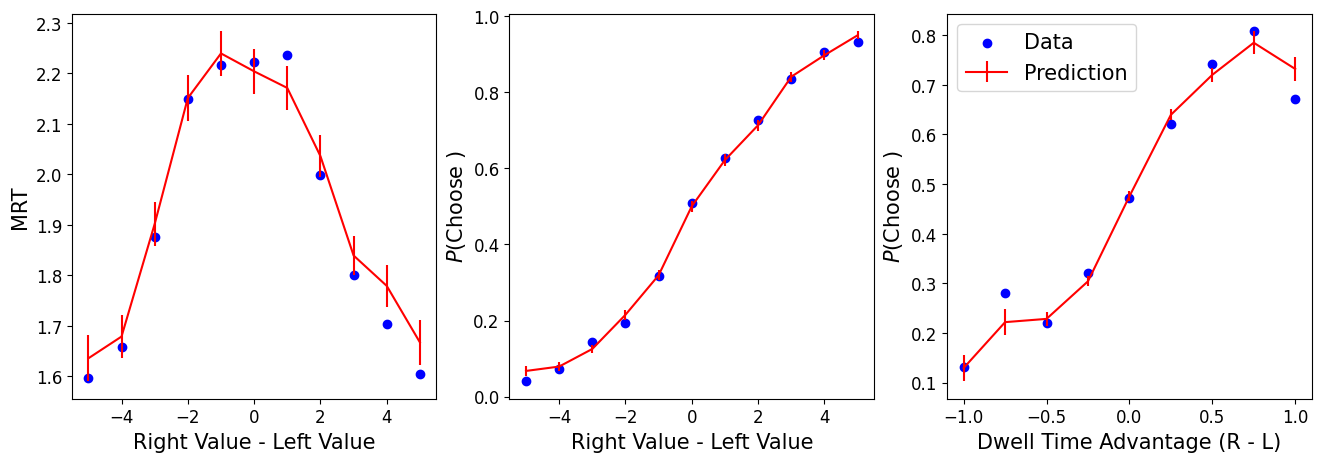

In [10]:
plt.figure(figsize=(16, 5))
plt.subplot(131)
se = pred_bhv.groupby(by='value_diff')['rt'].sem()
h = se * scipy.stats.t.ppf(1.95 / 2., pred_bhv.shape[0])
plt.errorbar(pred_bhv.groupby(by='value_diff')['value_diff'].mean(),
             pred_bhv.groupby(by='value_diff')['rt'].mean(),
             yerr=h, c='red')
plt.scatter(x=ts_df.groupby(by='Right Value - Left Value')['Right Value - Left Value'].mean(), 
            y=ts_df.groupby(by='Right Value - Left Value')['rt'].mean(), c='blue');
plt.xlabel('Right Value - Left Value');
plt.ylabel('MRT');

plt.subplot(132)
se = pred_bhv.groupby(by='value_diff')['ch'].sem()
h = se * scipy.stats.t.ppf(1.95 / 2., pred_bhv.shape[0])
plt.errorbar(x=pred_bhv.groupby(by='value_diff')['value_diff'].mean(), 
             y=pred_bhv.groupby(by='value_diff')['ch'].mean(),
             yerr=h, c='red');
plt.scatter(x=ts_df.groupby(by='Right Value - Left Value')['Right Value - Left Value'].mean(), 
            y=ts_df.groupby(by='Right Value - Left Value')['choice'].mean()-1, c='blue');
plt.xlabel('Right Value - Left Value');
plt.ylabel(r'$P$(Choose )');

plt.subplot(133)
se = pred_bhv.groupby(by='gaze_diff')['ch'].sem()
h = se * scipy.stats.t.ppf(1.95 / 2., pred_bhv.shape[0])
plt.errorbar(x=pred_bhv.groupby(by='gaze_diff')['gaze_diff'].mean(),
             y=pred_bhv.groupby(by='gaze_diff')['ch'].mean(),
             yerr=h, label='Prediction', c='red');
plt.scatter(x=ts_df.groupby(by='Dwell Time Advantage (R - L)')['Dwell Time Advantage (R - L)'].mean(), 
            y=ts_df.groupby(by='Dwell Time Advantage (R - L)')['choice'].mean()-1, 
            c='blue', label='Data');
plt.xlabel('Dwell Time Advantage (R - L)');
plt.ylabel(r'$P$(Choose )');
plt.legend();

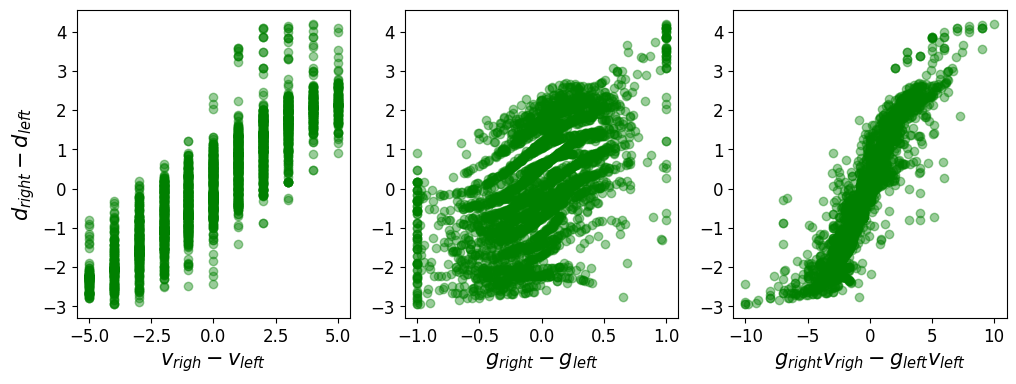

In [11]:
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.scatter(X_test[:, 0] - X_test[:, 1], 
            pred_v[:, 0] - pred_v[:, 1], alpha=0.4, c='green');
plt.ylabel(r'$d_{right} - d_{left}$');
plt.xlabel(r'$v_{righ} - v_{left}$ ');

plt.subplot(132)
plt.scatter(X_test[:, 2] - X_test[:, 3], 
            pred_v[:, 0] - pred_v[:, 1], alpha=0.4, c='green');
plt.xlabel(r'$g_{right} - g_{left}$ ');

plt.subplot(133)
plt.scatter(X_test[:, 0]*X_test[:, 2] - X_test[:, 1]*X_test[:, 3], 
            pred_v[:, 0] - pred_v[:, 1], alpha=0.4, c='green');
plt.xlabel(r'$g_{right} v_{righ} - g_{left} v_{left}$ ');